In [1]:
from pydriveless import SearchFrame, angle
from ensemble import PhysicalParameters
import numpy as np
import cv2
import matplotlib.pyplot as plt



/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


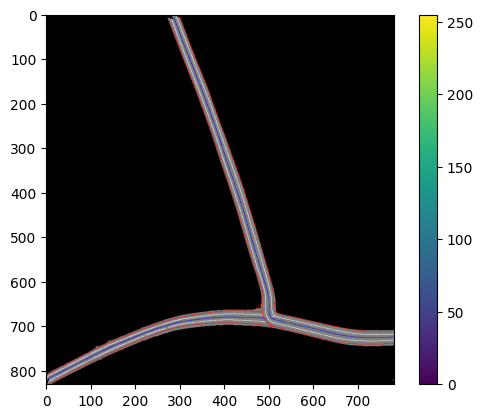

In [2]:
img = np.array(cv2.imread("converted_bev_23.png"), dtype=np.float32)

COSTS = np.array([-1, 0, 0, 0, 0])
COLORS = np.array([
            [0, 0, 0],
            [128, 128, 128],
            [0, 0, 255],
            [255, 255, 255],
            [255, 0, 0]
        ])

frame = SearchFrame (
    width=img.shape[1],
    height=img.shape[0],
    lower_bound=(-1, -1),
    upper_bound=(-1, -1))
    
frame.set_class_costs(COSTS)
frame.set_class_colors(COLORS)
frame.set_frame_data(img)

plt.imshow(frame.get_color_frame())
plt.colorbar()
plt.show()


Preprocessing of Search Space for Collision

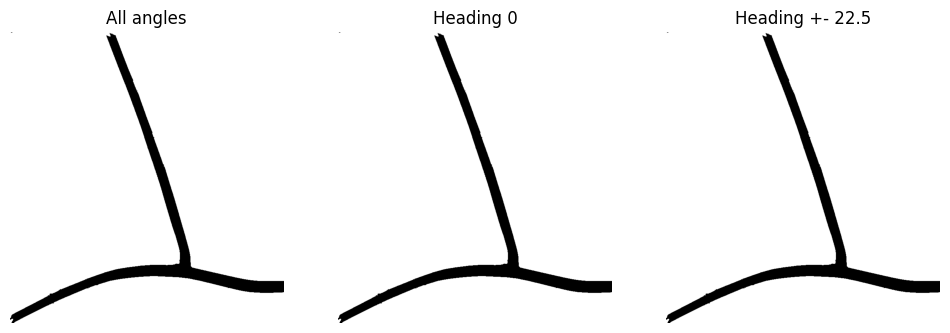

In [3]:
frame.process_safe_distance_zone((2, 2), True)
frame.process_distance_to_goal(107, 0)

f = frame.get_frame()
fp_all = np.zeros(f.shape, dtype=np.uint8)
fp_zero = np.zeros(f.shape, dtype=np.uint8)
fp_22 = np.zeros(f.shape, dtype=np.uint8)

for z in range(f.shape[0]):
    for x in range(f.shape[1]):
        if int(f[z, x, 2]) == 0x00:
            fp_all[z, x, :] = [255, 255, 255]
            fp_zero[z, x, :] = [255, 255, 255]
            fp_22[z, x, :] = [255, 255, 255]
            continue
        if (int(f[z, x, 2]) & 0x04) <= 0 and (int(f[z, x, 2]) & 0x10) <= 0:
            fp_22[z, x, :] = [128, 128, 128]

        if (int(f[z, x, 2]) & 0x08) <= 0:
            fp_zero[z, x, :] = [128, 128, 128]
                        
        if (int(f[z, x, 2]) & 0x100) <= 0:
            fp_all[z, x, :] = [128, 128, 128]
            


fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(fp_all)
axes[0].set_title("All angles")
axes[0].axis("off")

axes[1].imshow(fp_zero)
axes[1].set_title("Heading 0")
axes[1].axis("off")

axes[2].imshow(fp_22)
axes[2].set_title("Heading +- 22.5")
axes[2].axis("off")

plt.show()


False
False


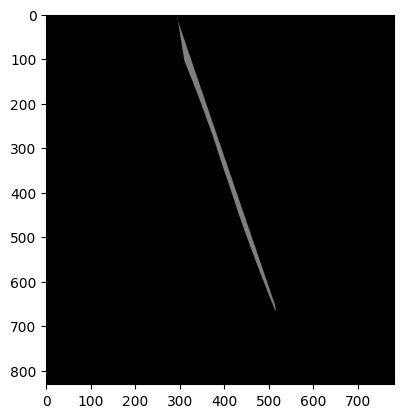

In [4]:
from pyfastrrt import CudaGraph

graph = CudaGraph(
    width=img.shape[1],
    height=img.shape[0],
    perception_width_m=PhysicalParameters.OG_REAL_WIDTH,
    perception_height_m=PhysicalParameters.OG_REAL_HEIGHT,
    lower_bound_x=-1,
    lower_bound_z=-1,
    upper_bound_x=-1,
    upper_bound_z=-1,
    max_steering_angle_deg=PhysicalParameters.MAX_STEERING_ANGLE,
    vehicle_length_m=PhysicalParameters.VEHICLE_LENGTH_M,
    path_costs=COSTS,
    min_dist_x=2,
    min_dist_z=2,
)

start = (416, 686, angle.new_deg(90 + -0.039754376).rad())
goal = (296, 15, angle.new_deg(-14).rad())

graph.add(start[0], start[1], angle.new_rad(start[2]), -1, -1, 0)

graph.process_direct_goal_connection(frame, goal[0], goal[1], angle.new_rad(goal[2]), max_curvature=0.34)

directly_connected_nodes = np.zeros(shape=(frame.height(), frame.width(), 3), dtype=np.uint8)
#f = frame.get_color_frame()
for z in range(frame.height()):
    for x in range(frame.width()):
        if graph.is_directly_connected_to_goal(x, z):
            directly_connected_nodes[z, x, :] = [128, 128, 128]

plt.imshow(directly_connected_nodes)
        

print( graph.is_directly_connected_to_goal(505, 649))
print( graph.is_directly_connected_to_goal(649, 505))

curve (416, 686, 1.57010252522764) --> (296, 15, -0.244346102) has max curvature of 0.016638286381240076
Node (416, 686) is NOT directly connected to goal


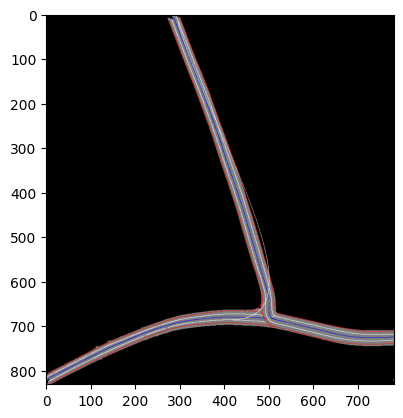

In [5]:
from hermite import HermiteCurve

points = HermiteCurve.interpolate(
    width=frame.width(), 
    height=frame.height(),
    p1=start,
    p2=goal,
    max_curvature=0.26)

f = frame.get_color_frame()

for p in points:
    f[p[1], p[0]] = [255, 255, 255]

plt.imshow(f)

if (graph.is_directly_connected_to_goal(start[0], start[1])):
    heading = graph.direct_connection_to_goal_heading(start[0], start[1])
    cost = graph.direct_connection_to_goal_cost(start[0], start[1])
    print(f"Node {start[0], start[1]} is directly connected to goal with heading = {heading.deg():.2f} deg and cost = {cost:.2f}")
else:
    print(f"Node {start[0], start[1]} is NOT directly connected to goal")

Analise das paths obtidas pela execução do FastRRT

In [6]:
import numpy as np
coarse = np.load("coarse_path.npy")

[[ 4.1600000e+02  6.8600000e+02  1.5701026e+00]
 [ 4.2700000e+02  6.9000000e+02  2.0762820e+00]
 [ 4.4400000e+02  6.8600000e+02  9.5347202e-01]
 [ 4.7600000e+02  6.7700000e+02  1.5463040e+00]
 [ 4.9500000e+02  6.6300000e+02  5.5440950e-01]
 [ 5.0000000e+02  6.6100000e+02  1.1332066e+00]
 [ 5.0200000e+02  6.3600000e+02 -6.0305643e-01]
 [ 4.9900000e+02  6.3000000e+02 -3.1882086e-01]
 [ 2.9600000e+02  1.5000000e+01 -2.4434610e-01]]
curve [416.        686.          1.5701026] --> [427.       690.         2.076282] has max curvature of 0.09267141815753618
curve [427.       690.         2.076282] --> [444.       686.         0.953472] has max curvature of 0.12756872439813574
curve [444.       686.         0.953472] --> [476.       677.         1.546304] has max curvature of 0.0271150320760562
curve [476.       677.         1.546304] --> [4.950000e+02 6.630000e+02 5.544095e-01] has max curvature of 0.07481529851647654
curve [4.950000e+02 6.630000e+02 5.544095e-01] --> [500.        661.       

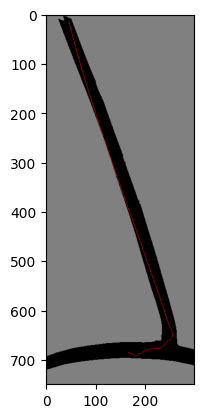

In [7]:
def gen_debug_frame(frame: SearchFrame, width: int = -1, height: int = -1, origin: tuple[int,int] = (0,0)) -> np.ndarray:
    f = frame.get_frame()
    if width <= 0: width = f.shape[1]
    if height <= 0: height = f.shape[0]

    fc = np.zeros((height, width, 3), dtype=np.uint8)

    for z in range(height):
        for x in range(width):
            xp = x + origin[0]
            zp = z + origin[1]
            if (f[zp, xp, 2] == 0.0):
                fc[z, x, :] = [128, 128, 128]
    return fc

origin = (250, 0)
fc = gen_debug_frame(frame, width=300, height=750, origin=origin)
#origin = (0, 0)
#fc = gen_debug_frame(frame)
print(coarse)

p1 = None
p2 = None
for p in coarse:
    p1 = p2    
    p2 = p
    if p1 is None: continue
        
    sub_path = HermiteCurve.interpolate(
        width=f.shape[1],
        height=f.shape[1],
        p1=p1,
        p2=p2,
        max_curvature=-1
    )

    for sp in sub_path:
        x = int(sp[0]) - origin[0]
        z = int(sp[1]) - origin[1]
        if x >= fc.shape[1]: continue
        if z >= fc.shape[0]: continue
        fc[z, x, :] = [255, 0, 0]

plt.imshow(fc)

curve [416.        686.          1.5701026] --> [427.       690.         2.076282] has max curvature of 0.09267141815753618
curve [427.       690.         2.076282] --> [444.       686.         0.953472] has max curvature of 0.12756872439813574
curve [444.       686.         0.953472] --> [476.       677.         1.546304] has max curvature of 0.0271150320760562
curve [476.       677.         1.546304] --> [4.950000e+02 6.630000e+02 5.544095e-01] has max curvature of 0.07481529851647654
curve [4.950000e+02 6.630000e+02 5.544095e-01] --> [500.        661.          1.1332066] has max curvature of 0.45853414030901946
curve [500.        661.          1.1332066] --> [ 5.0200000e+02  6.3600000e+02 -6.0305643e-01] has max curvature of 0.1301027424189947
curve [ 5.0200000e+02  6.3600000e+02 -6.0305643e-01] --> [ 4.9900000e+02  6.3000000e+02 -3.1882086e-01] has max curvature of 0.04547840277308648
curve [ 4.9900000e+02  6.3000000e+02 -3.1882086e-01] --> [ 2.960000e+02  1.500000e+01 -2.443461e-0

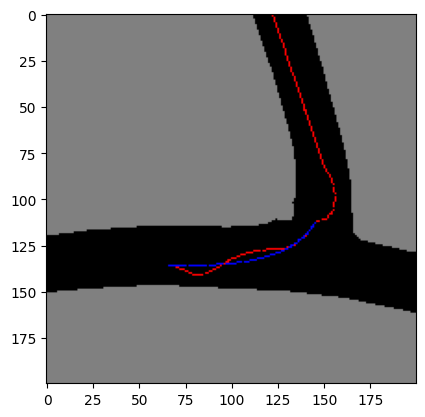

In [8]:
origin = (350, 550)
fc = gen_debug_frame(frame, width=200, height=200, origin=origin)

p1 = None
p2 = None
for p in coarse:
    p1 = p2    
    p2 = p
    if p1 is None: continue
        
    sub_path = HermiteCurve.interpolate(
        width=f.shape[1],
        height=f.shape[1],
        p1=p1,
        p2=p2,
        max_curvature=-1
    )

    for sp in sub_path:
        x = int(sp[0]) - origin[0]
        z = int(sp[1]) - origin[1]
        if x <= 0 or x>= fc.shape[1]: continue
        if z <= 0 or z >= fc.shape[0]: continue
        fc[z, x, :] = [255, 0, 0]

init = 0
end = 4
print (f"interpolating {coarse[init]} -> {coarse[end]}")

points = HermiteCurve.interpolate(
    width=frame.width(), 
    height=frame.height(),
    p1=coarse[init],
    p2=coarse[end],
    max_curvature=0.1)

for sp in points:
        x = int(sp[0]) - origin[0]
        z = int(sp[1]) - origin[1]
        if x <= 0 or x>= fc.shape[1]: continue
        if z <= 0 or z >= fc.shape[0]: continue
        fc[z, x, :] = [0, 0, 255]


plt.imshow(fc)